# The model

$$
\begin{align}
V(s,a)=&\max_{a'}u\left((1+r)a+y(s)-a'\right)+\beta\mathbb{E}[V(s',a')|s]\\
&\text{s.t. }a'\geq \underline{a}
\end{align}
$$

Compare to neoclassical growth model?
- Simpler because return $r$ is exogenous
- More complex because there's an exogenous lower bound $\underline{a}$ that we expect to occasionally bind

# Some anticipatory comments
- The occasionally binding lower bound $\underline{a}$ is tricky because it introduces a kink at $\underline{a}$ into policy functions...


- Which, with discrete states $s$, propagates into additional kinks elsewhere in the policy function!
    - e.g. kink at "level of assets where I am going to exactly hit $\underline{a}$ in four periods if this state $s$ persists"


- Since the true policy function has kinks, using smooth interpolation methods like Chebyshev polynomials or even cubic splines unlikely to work well
    - this doesn't stop some people from plowing ahead with these approaches, not really knowing what they're doing...
    
    
- So we're back to the old mainstay: grids and linear interpolation
    - this is what the endogenous gridpoint method was invented for
    - another reason to worry about Chebyshev: even aside from kinks, point of this model is to have large nonlinearities (e.g. derivative of consumption function, MPCs, varying a lot across the distribution)
    - but one of my goals to find good ways to "smooth out" the underlying model so we can apply better solution methods

# Envelope and FOC
Restate problem:

$$
\begin{align}
V(s,a)=&\max_{a_+}u\left((1+r)a+y(s)-a_+\right)+\beta\mathbb{E}[V(s_+,a_+)|s]\\
&\text{s.t. }a_+\geq \underline{a}
\end{align}
$$

Envelope and FOC:

$$
\begin{align}
V_a(s,a) &= (1+r)u'(c)\\
u'(c) &= \beta \mathbb{E}[V_a(s_+,a_+)|s]
\end{align}
$$

where we note that the FOC only holds when constraint does not bind.

# Euler equation
Envelope and FOC:

$$
\begin{align}
V_a(s,a) &= (1+r)u'(c(s,a))\\
u'(c(s,a)) &= \beta \mathbb{E}[V_a(s_+,a_+)|s]
\end{align}
$$

Plug first into right of second to get **Euler equation**

$$
u'(c(s,a)) = \beta (1+r)\mathbb{E}[u'(c(s_+,a_+(s,a))|s]
$$

Now let's use that Euler equation to do backward iteration.

# Given $c_+$, solve for $c$ (and thus $a_+$)
Given function $c_+(s_+, a_+)$ for tomorrow's consumption, let $c^{endog}(s, a_+)$ be a function for consumption today that satisfies the Euler equation (but is specified in terms of tomorrow's assets $a_+$):

$$
c^{endog}(s, a_+) = (u')^{-1}\left(\beta(1+r) \mathbb{E}[u'(c_+(s_+,a_+)|s]\right)
$$

Once we have $c^{endog}(s, a_+)$, letting $a(s, a_+)$ be the inverse of the policy rule, note that we have the following system of equations:

$$
\begin{align}
(1+r)a + y(s) &= c^{endog}(s, a_+) + a_+ \\
c(s, a(s, a_+)) &= c^{endog}(s, a_+)
\end{align}
$$

We know both of the right side for our grid of $a_+$, and we know $(1+r)a+y(s)$ on the left (which we sometimes call "cash on hand". So by *interpolating* the points $(c^{endog}(s, a_+) + a_+, c^{endog}(s, a_+))$ at $(1+r)a + y(s)$, we get $c(s, a)$ at those points.

# First step: from $c_+$ to $c^{endog}$
$$
c^{endog}(s, a_+) = (u')^{-1}\left(\beta (1+r)\mathbb{E}[u'(c(s_+,a_+)|s]\right)
$$


In [1]:
def get_cendog(cplus, up, up_inv, beta, r, Pi):
    return up_inv(beta * (1+r) * Pi @ up(cplus))

# Second step: from $c^{endog}$ to $c_+$
Interpolate using right as sample points:

$$
\begin{align}
(1+r)a + y(s) &= c^{endog}(s, a_+) + a_+ \\
c(s, a(s, a_+)) &= c^{endog}(s, a_+)
\end{align}
$$

In [2]:
import numpy as np
def get_c(cendog, r, y, a):
    c = np.empty_like(endog)
    for s, y in enumerate(y):
        c[s, :] = np.interp(y[s] + (1+r)*a, cendog[s, :] + a, cendog[s, :])
    return c

# What did we forget?
- Oh, right, the Euler equation doesn't always hold with equality if the constraint $a_+ \geq \underline{a}$ is binding!


- Turns out that if our implied policy function $a_+$ from this endogenous gridpoints approach is greater than $\underline{a}$, we're fine: all the equations hold for this to be an interior solution


- Since this is such a simple problem, if we get $a_+ < \underline{a}$, we know the constraint must be binding and can just set $a_+ = \underline{a}$.

# Overall backward iteration code

In [3]:
def backward_iterate(cplus, up, up_inv, beta, Pi, r, y, a):
    # step one: get consumption on endogenous gridpoints 
    cendog = up_inv(beta * (1+r) * Pi @ up(cplus))
    
    # step two: solve for consumption on regular gridpoints implied by Euler equation
    coh = y[:, np.newaxis] + (1+r)*a
    c = np.empty_like(cendog)
    for s, y in enumerate(y):
        c[s, :] = np.interp(coh[s, :], cendog[s, :] + a, cendog[s, :])
    
    # step three: enforce a_+ >= amin, assuming amin is lowest gridpoint of a
    aplus = coh - c
    aplus[aplus < a[0]] = a[0]
    c = coh - aplus
    
    return c, aplus

# Include functions for calibration
Just throw in same copy-paste stuff as before for discretizing Markov chain.

In [4]:
import numpy as np
from scipy.stats import norm

In [5]:
def stationary(Pi, pi_seed=None, tol=1E-11, maxit=10_000):
    """Find invariant distribution of a Markov chain by iteration."""
    if pi_seed is None:
        pi = np.ones(Pi.shape[0]) / Pi.shape[0]
    else:
        pi = pi_seed

    for it in range(maxit):
        pi_new = pi @ Pi
        if np.max(np.abs(pi_new - pi)) < tol:
            break
        pi = pi_new
    else:
        raise ValueError(f'No convergence after {maxit} forward iterations!')
    pi = pi_new

    return pi

In [6]:
def variance(x, pi):
    """Variance of discretized random variable with support x and probability mass function pi."""
    return np.sum(pi * (x - np.sum(pi * x)) ** 2)

In [7]:
def markov_rouwenhorst(rho, sigma, N=7):
    # parametrize Rouwenhorst for n=2
    p = (1 + rho) / 2
    Pi = np.array([[p, 1 - p], [1 - p, p]])

    # implement recursion to build from n=3 to n=N
    for n in range(3, N + 1):
        P1, P2, P3, P4 = (np.zeros((n, n)) for _ in range(4))
        P1[:-1, :-1] = p * Pi
        P2[:-1, 1:] = (1 - p) * Pi
        P3[1:, :-1] = (1 - p) * Pi
        P4[1:, 1:] = p * Pi
        Pi = P1 + P2 + P3 + P4
        Pi[1:-1] /= 2

    # invariant distribution and scaling
    pi = stationary(Pi)
    s = np.linspace(-1, 1, N)
    s *= (sigma / np.sqrt(variance(s, pi)))
    y = np.exp(s) / np.sum(pi * np.exp(s))

    return y, pi, Pi

# And some new code for making grid of a

In [8]:
def agrid(amax,N,amin=0,pivot=0.1):
    """Grid with a+pivot evenly log-spaced between amin+pivot and amax+pivot"""
    a = np.geomspace(amin+pivot,amax+pivot,N) - pivot
    a[0] = amin # make sure *exactly* equal to amin
    return a

# Calibration
Let's think of this as a quarterly calibration - we'll pick roughly reasonable values given that. The standard deviation of 0.7 of log income reflects some estimates of the standard deviation of the persistent component of log income in the US.

In [9]:
# persistence and standard deviation of log incomes roughly reflects actual
y, pi, Pi = markov_rouwenhorst(0.975, 0.7)

a = agrid(amin=0, amax=200, N=500)

def up(c):
    return 1/c

def up_inv(c):
    return 1/c

beta = 1 - 0.08/4
r = 0.01/4
coh = y[:, np.newaxis] + a

In [10]:
y

array([0.1413694 , 0.25036602, 0.44339966, 0.78526334, 1.3907059 ,
       2.46294815, 4.36189533])

In [11]:
pi

array([0.015625, 0.09375 , 0.234375, 0.3125  , 0.234375, 0.09375 ,
       0.015625])

# Solve for (steady state) policies
A bit slower than usual since backward iteration is going quarter-by-quarter rather than year-by-year.

In [12]:
def ss_policy(up, up_inv, beta, Pi, r, y, a):
    # guess initial value for consumption function as 10% of cash on hand
    coh = y[:, np.newaxis] + (1+r)*a
    
    c = 0.1*coh
    
    # iterate until convergence
    for it in range(2000):
        c, aplus = backward_iterate(c, up, up_inv, beta, Pi, r, y, a)
        
        if it % 10 == 1 and np.max(np.abs(c - cold)) < 1E-9:
            return c, aplus
        
        cold = c        

In [13]:
ss_policy(up, up_inv, beta, Pi, r, y, a)
%time c, aplus = ss_policy(up, up_inv, beta, Pi, r, y, a)

CPU times: user 67.8 ms, sys: 902 µs, total: 68.7 ms
Wall time: 73.5 ms


# Savings policies by income state

In [14]:
import matplotlib.pyplot as plt

In [15]:
# side comment: apparently these need to be in a different cell from the import
# for jupyter to always recognize them, for some reason...
plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams['font.size'] = 22

Lowest income states: first four, disaccumulate until you reach zero, then for next, target a positive level.

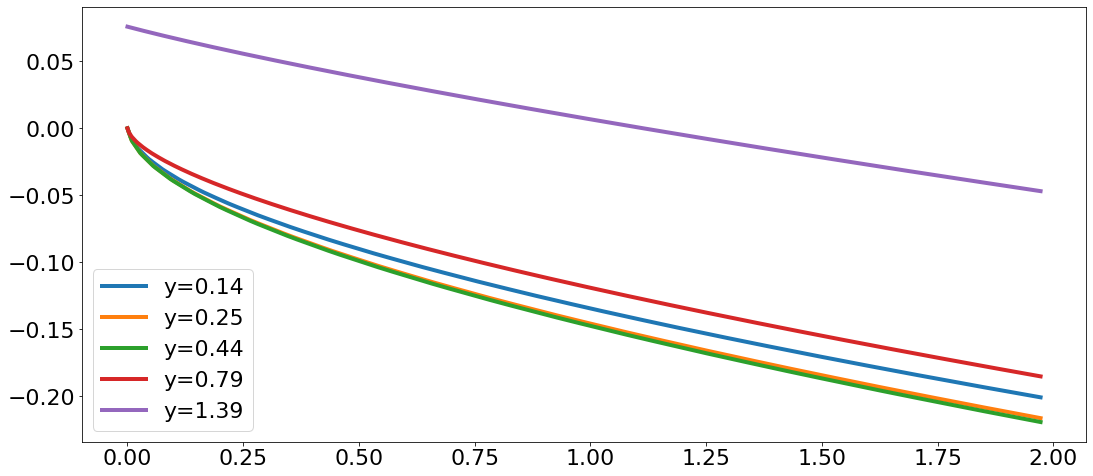

In [16]:
for iy in range(5):
    plt.plot(a[:200], aplus[iy,:200]-a[:200], label=f'y={y[iy]:.2f}', linewidth=4)
plt.legend();

# Savings policies by income state, continued
Higher income states much more aggressive about savings, the asset targets are far higher.

Note that this is a force for a fair amount of inequality in assets!

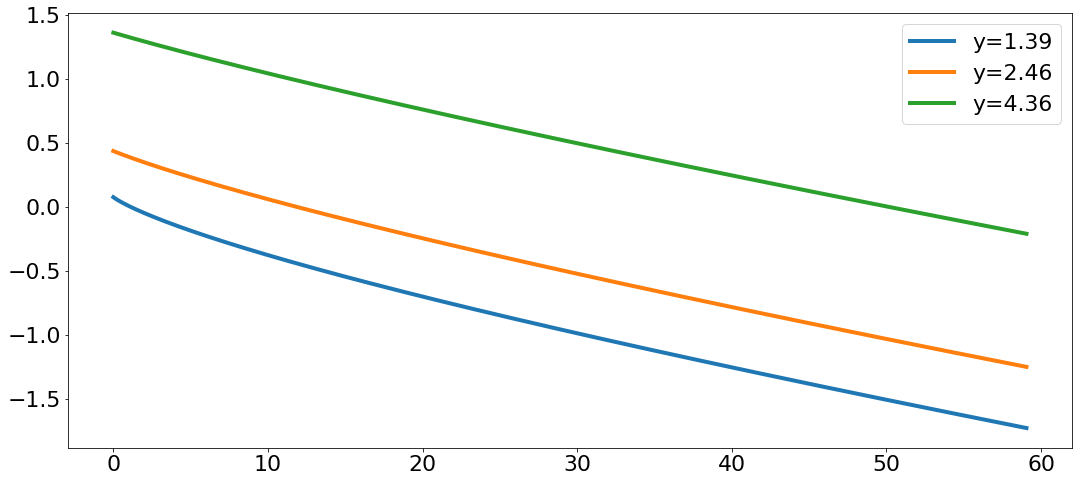

In [17]:
for iy in range(4, 7):
    plt.plot(a[:420], aplus[iy,:420]-a[:420], label=f'y={y[iy]:.2f}', linewidth=4)
plt.legend();

# Flip side: consumption policy funciton
Plot for the lowest income state. Here, we can see the *concavity* of the consumption function, as per Carroll and Kimball.

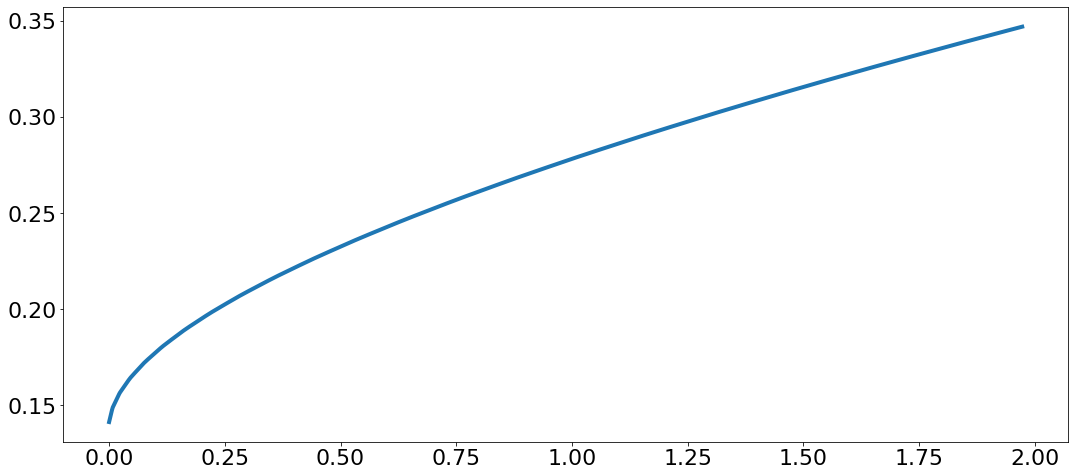

In [18]:
plt.plot(a[:200], c[0,:200], linewidth=4);

# Less concave for higher incomes

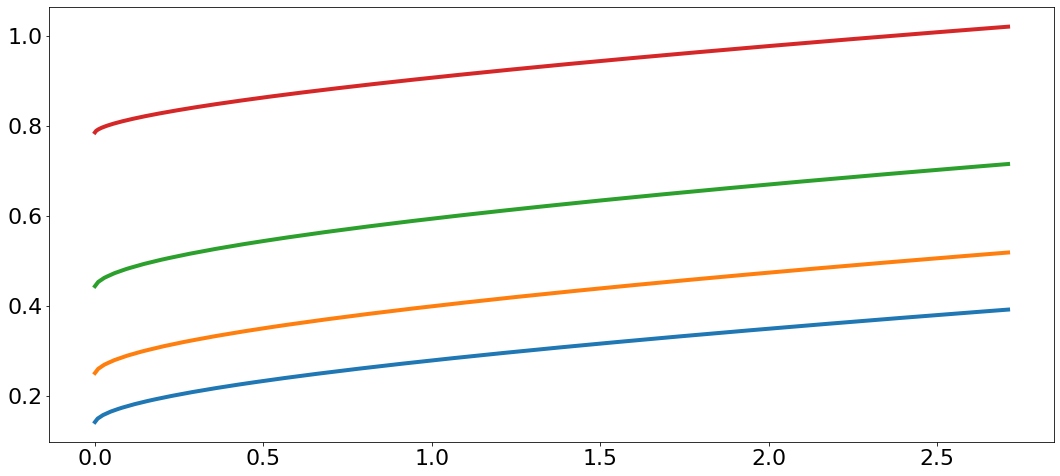

In [19]:
for s in range(4):
    plt.plot(a[:220], c[s, :220], linewidth=4)

# Derivative of consumption function: MPCs
The derivative of this consumption function (divided by $1+r$ to adjust for the fact that assets are pre-return) is what we call the marginal propensity to consume, or MPC. Concavity of the consumption function means that this derivative is declining.

Let's calculate the MPCs given policies, using simple numerical differentiation on the grid (maybe not the most precise approach, but then again we have discontinuous MPCs!).

In [20]:
def mpcs(a, c, aplus, r):
    mpcs = np.empty_like(c)
    
    # symmetric differences away from boundaries
    mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a[2:] - a[:-2]) / (1+r)

    # asymmetric first differences at boundaries
    mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a[1] - a[0]) / (1+r)
    mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a[-1] - a[-2]) / (1+r)

    # special case of constrained
    mpcs[aplus == a[0]] = 1
    
    return mpcs

In [21]:
%time mpc = mpcs(a, c, aplus, r)

CPU times: user 450 µs, sys: 184 µs, total: 634 µs
Wall time: 511 µs


# Visualize MPCs over all income states
Note the discontinuities: these aren't accidental! The discreteness of the Markov chain means that as we change asset positions, there are discrete jumps in the likely horizon: for instance, in the event we stay in the same state, there's an asset threshold where we will go from being constrained two periods from now to being constrained three periods from now. When we hit this threshold, our MPC discontinuously falls.

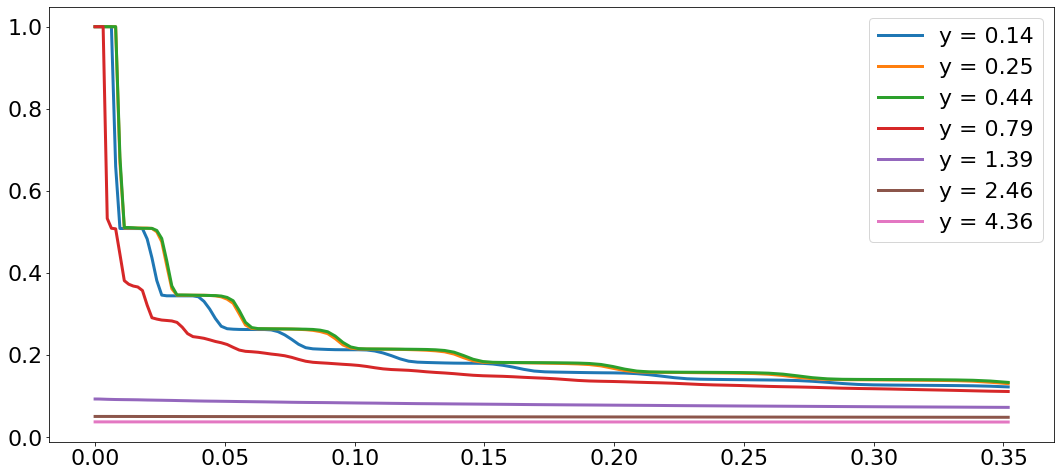

In [22]:
for s in range(7):
    plt.plot(a[:100], mpc[s, :100], linewidth=3, label=f'y = {y[s]:.2f}')
plt.legend();

# Getting the distribution

# Getting the distribution
We now want to get the *steady-state distribution* of a continuum of agents all following these policies and being hit by iid shocks. We'll use a strategy we used before in the neoclassical growth model: discretize the state space into a bunch of points, and then find an interpolated "lottery" policy rule between these points.

Since our policy function is already only accurate at the level of linear interpolation (rather than the absurdly accurate Chebyshev polynomials we had before), for now I'll just use the same grid here.

To implement this, we'll just copy functions from the neoclassical growth model notebook, renaming from `ergodic_dist` to `ss_dist`.

(Note: in general copying functions is **terrible** practice, and we should put these in well-organized modules, but early in the class I want these notebooks to be self-contained.)

# First step: interpolated policy rule

In [23]:
import numba
@numba.njit
def interpolate_coord(x, xq):
    """Get representation xqi, xqpi of xq interpolated against x:
    xq = xqpi * x[xqi] + (1-xqpi) * x[xqi+1]

    Parameters
    ----------
    x    : array (n), ascending data points
    xq   : array (nq), ascending query points

    Returns
    ----------
    xqi  : array (nq), indices of lower bracketing gridpoints
    xqpi : array (nq), weights on lower bracketing gridpoints
    """
    nxq, nx = xq.shape[0], x.shape[0]
    xqi = np.empty(nxq, dtype=np.int64)
    xqpi = np.empty(nx)

    xi = 0
    x_low = x[0]
    x_high = x[1]
    for xqi_cur in range(nxq):
        xq_cur = xq[xqi_cur]
        while xi < nx - 2:
            if x_high >= xq_cur:
                break
            xi += 1
            x_low = x_high
            x_high = x[xi + 1]

        xqpi[xqi_cur] = (x_high - xq_cur) / (x_high - x_low)
        xqi[xqi_cur] = xi
    return xqi, xqpi

In [24]:
aplus_i = np.empty(aplus.shape, dtype=np.int64)
aplus_pi = np.empty(aplus.shape)
for s in range(len(y)):
    aplus_i[s,:], aplus_pi[s,:] = interpolate_coord(a, aplus[s, :])

# Copy code for updating distribution

In [25]:
@numba.njit
def forward_iterate(D, Pi_T, aplus_i, aplus_pi):
    # first step: update using endogenous asset policy
    # initialize Dnew with zeros because we're looping through D, not Dnew
    Dnew = np.zeros_like(D)
    for si in range(D.shape[0]):
        for ai in range(D.shape[1]):
            i = aplus_i[si, ai]
            pi = aplus_pi[si, ai]
            d = D[si, ai]
            
            Dnew[si, i] += d*pi
            Dnew[si, i+1] += d*(1-pi)
    
    # second step: update using transpose of Markov matrix for exogenous state z
    # take Pi_T itself as input for memory efficiency
    return Pi_T @ Dnew

# And for finding the ergodic (now steady-state) distribution

In [26]:
def ss_dist(Pi, aplus_i, aplus_pi):
    # start by getting stationary distribution of s
    pi = stationary(Pi)
    
    # need to initialize joint distribution of (s, a), assume uniform on a
    nA = aplus_i.shape[1]
    D = np.outer(pi, np.full(nA, 1/nA))
    
    # Pi.T is a "view" on Pi with the wrong memory order, copy this to get right memory order (faster operations)
    Pi_T = Pi.T.copy()
    
    # now iterate forward until convergence
    for it in range(100_000):
        Dnew = forward_iterate(D, Pi_T, aplus_i, aplus_pi)
        
        # only check convergence every 20 iterations for efficiency
        if it % 20 == 0 and np.max(np.abs(Dnew-D)) < 1E-10:
            print(f'Convergence after {it} forward iterations!')
            break
        D = Dnew
    else:
        raise ValueError(f'No convergence after {maxit} forward iterations!')
    
    return D

In [27]:
ss_dist(Pi, aplus_i, aplus_pi)
%time D = ss_dist(Pi, aplus_i, aplus_pi)

Convergence after 420 forward iterations!
Convergence after 420 forward iterations!
CPU times: user 15.9 ms, sys: 1.89 ms, total: 17.8 ms
Wall time: 16.3 ms


# Visualize distribution
Not such an ugly CDF here, but with a pronounced kink point that (I believe) corresponds to the target level of assets for the middle state?

And **wow**, half of agents literally have zero assets! That's pretty extreme - probably too extreme (though if we're talking about liquid assets, that isn't so far from reality for the US).

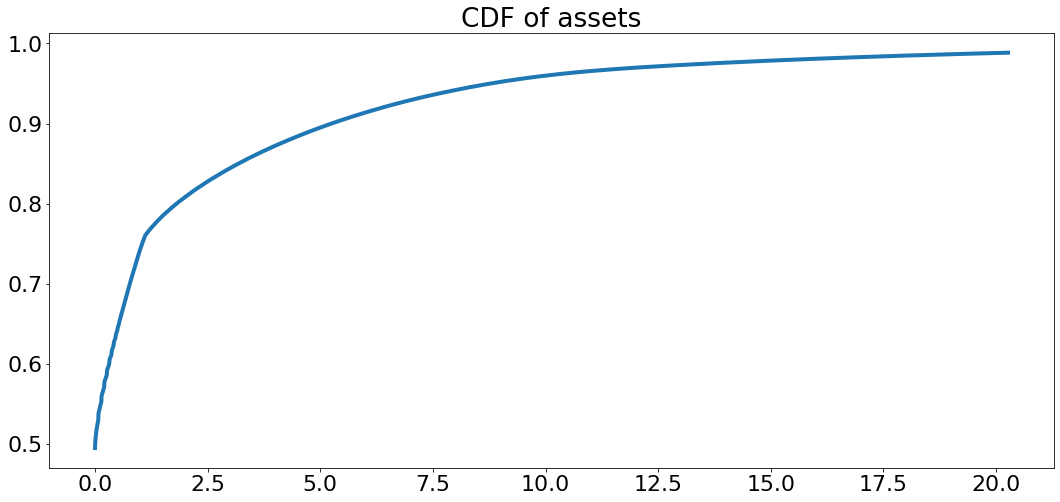

In [28]:
plt.plot(a[:350], D.sum(axis=0).cumsum()[:350], linewidth=4)
plt.title('CDF of assets');

# Now visualize by income state
Lots of heterogeneity by incomes: you see that the income process is really driving this.

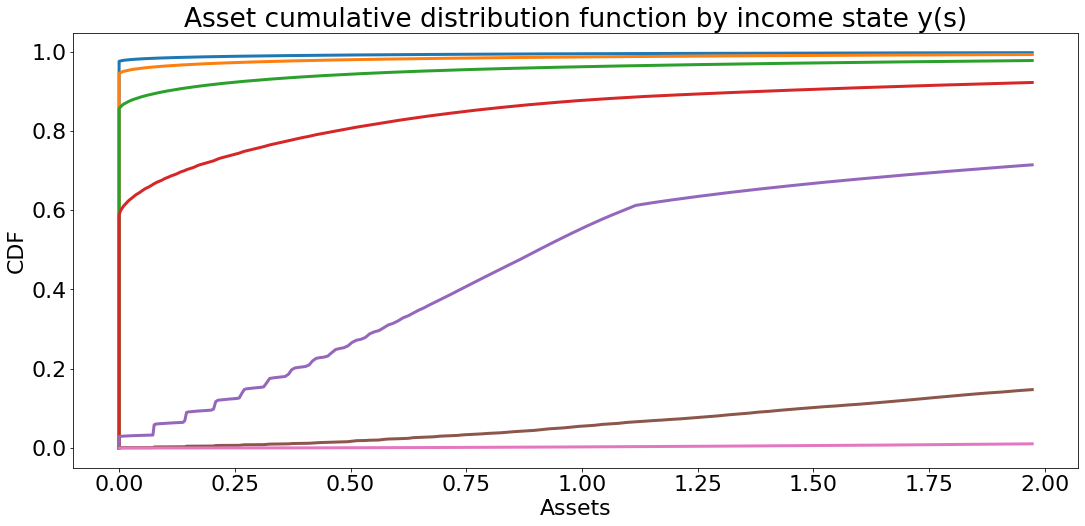

In [29]:
for s in range(7):
    cumdist = np.concatenate(([0], D[s, :200].cumsum())) / D[s, :].sum()
    grid = np.concatenate(([a[0]], a[:200]))
    plt.plot(grid, cumdist, linewidth=3, label=f'y = {y[s]:.2f}')
plt.xlabel('Assets');
plt.ylabel('CDF')
plt.title('Asset cumulative distribution function by income state y(s)');

# Lorenz curve

We could also plot the Lorenz curve: the cumulative percentile of total assets against the cumulative percentile of the population. This is a common measure of total inequality for assets or income.

In [30]:
combined_dist = D.sum(0)
combined_asset_dist = combined_dist*a/np.sum(D*a)
cumulative_dist = combined_dist.cumsum()
cumulative_asset_dist = combined_asset_dist.cumsum()

# add zeros to the bottom of these so graph starts at (0, 0)
cumulative_dist = np.concatenate(([0], cumulative_dist))
cumulative_asset_dist = np.concatenate(([0], cumulative_asset_dist))

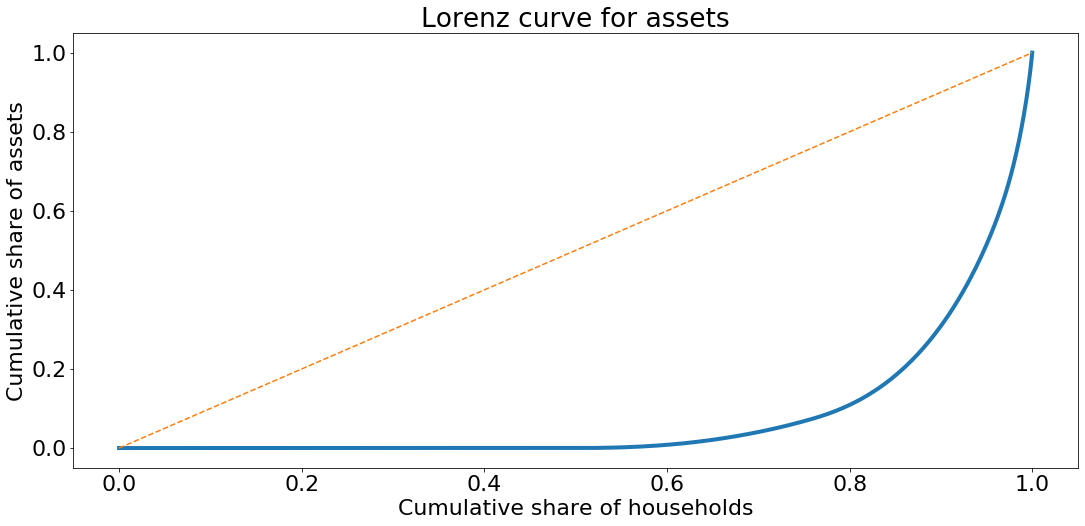

In [31]:
plt.plot(cumulative_dist, cumulative_asset_dist, linewidth=4)
plt.plot(cumulative_dist, cumulative_dist, '--')
plt.xlabel('Cumulative share of households')
plt.ylabel('Cumulative share of assets')
plt.title('Lorenz curve for assets');

# Gini coefficient
The Gini coefficient is the gap between the 45 degree line and the Lorenz curve, times two. Under perfect equality it's 0; under perfect inequality it's 1.

In [32]:
from scipy.integrate import trapz
under_curve = trapz(cumulative_asset_dist, cumulative_dist)
gini = 1-2*under_curve
gini

0.8324053871328958

This is an *extremely high* level.